# Muscle Activity Analysis

## Introduction

In this jupyter notebook, we will study the muscle activities of the various muscles of our human 2D musculoskeletal reflex model, from Song and Geyer, 2015. We will then be able to compare the obtained results from the optimizations with experimental data from other research groups. 



% Est-ce que je développe un peu le blabla ici. A voir

In [1]:
# Imports
from wNMF import wNMF
import numpy as np
import matplotlib.pyplot as plt   # allows to plot charts
import pandas as pd              
import seaborn as sns    # python data visualization library based on matplotlib
import glob
import pickle
import os 

# To be allow to zoom in on the plots, uncomment the following lines
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

sns.set(style="darkgrid")


We first study 3 types of contribution and compare them with real experimental data:
- cpg: corresponds to the CPG contribution to the motoneurons, before the linear combination of the reflexes with the CPG
- reflex: corresponds to the reflex contribution to the motoneurons, before the linear combination of the reflexes with the CPG
- muscle: corresponds to motoneurons activities (which registers muscle activations)

To do so, we import the .pkl files from the optimizations. A PKL file is one that is created by the Python module 'pickle' that enables objects to be serialized. These files contain byte streams that represents the objects. Thus, after importing, we extract the different .pkl files. 

In [2]:
# File selection of the reflex activities and muscle activities
f = open('Checkpoints/Best_292/checkpoint-2D-CMAES_130_muscle.pkl','rb')
g = open('Checkpoints/Best_292/checkpoint-2D-CMAES_130_reflex.pkl','rb')
h = open('Checkpoints/Best_292/checkpoint-2D-CMAES_130_values.pkl', 'rb')
i = open('Checkpoints/Best_350/checkpoint-2D-CMAES_135_values.pkl', 'rb')
muscle = pickle.load(f)
reflex = pickle.load(g)
values = pickle.load(h)
ivalues = pickle.load(i)



    
#def plotStdTrend(data, start_cycles, end_cycles):
#    Y = []
#    for start_cycle, end_cycle in zip(start_cycles, end_cycles):
#        yp = data[start_cycle:end_cycle]
#        xp = range(len(yp))
#        x = np.linspace(0,len(yp),N)
#        y = np.interp(x, xp, yp)
#        Y.append(y)
#    Y = np.array(Y).transpose();
    
#    z = np.polyfit(x, Y, 1)
#    p = np.poly1d(z)
#    plt.plot(Y,p(Y),"r--")

In [3]:
# Interpolation for all cycles
def getNormalizedData(data, start_cycles, end_cycles):
    Y = []
    for start_cycle, end_cycle in zip(start_cycles, end_cycles):
        yp = data[start_cycle:end_cycle]
        xp = range(len(yp))
        x = np.linspace(0,len(yp),N)
        y = np.interp(x, xp, yp)
        Y.append(y)
    Y = np.array(Y).transpose();
    return Y

# Plots with the standard deviation around the mean
def plotWithStd(normalized_data, title, xlabel, ylabel, legendlabel, color):
    m = np.mean(normalized_data,1)
    s = np.std(normalized_data,1)
    LENGTH = normalized_data.shape[0]
    
    plt.plot(m, label=legendlabel, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.fill_between(np.linspace(0,LENGTH,LENGTH),m-s, m+s ,alpha=0.3, color=color)
    
# Not WORKING YET
def plotStdStance(normalized_data, ymin, ymax, color, linestyle):
    normalized_list = normalized_data.reshape(-1,1)
    #normalized_list = normalized_data.tolist()
    m = np.mean(normalized_list,1)
    s = np.std(normalized_list,1)
    LENGTH = normalized_data.shape[0]
    
    fig, ax = plt.subplots()
    ax.vlines(m, ymin, ymax, color=color, linestyle=linestyle)
    plt.fill_between(np.linspace(0, LENGTH, LENGTH), m-s, m+s, alpha=0.3, color=color)

# Plots with the standard deviation around the mean
def plotMeanStd(norm_mean, norm_min, norm_max, title, xlabel, ylabel, legendlabel, legendLoc, color):
    LENGTH = norm_mean.shape[0]
    plt.plot(norm_mean, label=legendlabel, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = legendLoc)
    plt.fill_between(np.linspace(0, LENGTH, LENGTH), norm_min, norm_max ,alpha=0.3, color=color)
    
# Cast value val to int
def CastValInt(dataframe):
    dataframe['index'] = dataframe['index'].astype(int)

# Cast value val to float
def CastValFloat(dataframe):
    dataframe['norm_min'] = dataframe['norm_min'].astype(float)
    dataframe['norm_mean'] = dataframe['norm_mean'].astype(float)
    dataframe['norm_max'] = dataframe['norm_max'].astype(float)

In [4]:
# Retrieve real human data from Geyer 2010 for joint angles as well as ground reaction forces to compare with
# the data retrieved from simulations

HipFlexion = pd.read_excel('RealHumanData/HipFlexion.ods', engine='odf')
KneeFlexion = pd.read_excel('RealHumanData/KneeFlexion.ods', engine='odf')
AnkleFlexion = pd.read_excel('RealHumanData/AnkleFlexion.ods', engine='odf')
GroundReactionForces = pd.read_excel('RealHumanData/GroundReactionForces.ods', engine='odf')

# Data formatting
HipFlex = pd.DataFrame(HipFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
KneeFlex = pd.DataFrame(KneeFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
AnkleFlex = pd.DataFrame(AnkleFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
GRF = pd.DataFrame(GroundReactionForces, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])


# Casting
CastValInt(HipFlex)
CastValFloat(HipFlex)
CastValInt(KneeFlex)
CastValFloat(KneeFlex)
CastValInt(AnkleFlex)
CastValFloat(AnkleFlex)
CastValInt(GRF)
CastValFloat(GRF)

# Table of the data
#HipFlex.head()
#KneeFlex.head()
#AnkleFlex.head()
GRF.head()

## HIP FLEXION PLOT 
HipFlex_mean = HipFlex['norm_mean']
HipFlex_min = HipFlex['norm_min']
HipFlex_max = HipFlex['norm_max']

KneeFlex_mean = KneeFlex['norm_mean']
KneeFlex_min = KneeFlex['norm_min']
KneeFlex_max = KneeFlex['norm_max']

AnkleFlex_mean = AnkleFlex['norm_mean']
AnkleFlex_min = AnkleFlex['norm_min']
AnkleFlex_max = AnkleFlex['norm_max']

GRF_mean = GRF['norm_mean']
GRF_min = GRF['norm_min']
GRF_max = GRF['norm_max']

## Plots

### Ground reaction forces

We need to extract the ground reaction forces, especially along the y-direction, so as to determine the phases of the gait, i.e. whether the model is in the stance or swing phase. To do so, we retrieve the values from the Python dictionnary values. Then, we plot the ground reaction forces along the y-axis so as to differentiate the swing and stance phases of the gait cycle. 
By plotting the array [450:450+125,], we can see only one cycle for each leg (left and right) and thus, applying a threshold of 0.4 will allow to separate the swing phase from the stance phase. 



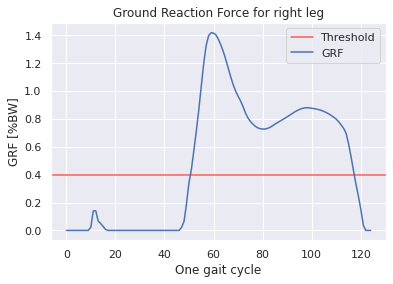

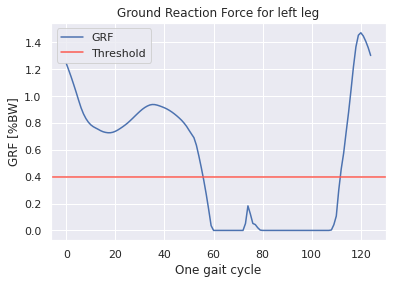

In [5]:
grf_axis_y_rleg = [values[i]["r_leg"]["ground_reaction_forces"][2] for i in range(len(values))]
grf_axis_y_lleg = [values[i]["l_leg"]["ground_reaction_forces"][2] for i in range(len(values))]

grf_350_rleg = [ivalues[i]["r_leg"]["ground_reaction_forces"][2] for i in range(len(ivalues))]
grf_350_lleg = [ivalues[i]["l_leg"]["ground_reaction_forces"][2] for i in range(len(ivalues))]

plt.axhline(y=0.4, color='xkcd:coral', linestyle='-', label='Threshold')
plt.plot(np.array(grf_axis_y_rleg)[450:450+125,], label='GRF')
plt.title('Ground Reaction Force for right leg')
plt.ylabel('GRF [%BW]')
plt.xlabel('One gait cycle')
plt.legend()
plt.show()

plt.plot(np.array(grf_axis_y_lleg)[450:450+125,], label='GRF')
plt.axhline(y=0.4, color='xkcd:coral', linestyle='-', label='Threshold')
plt.title('Ground Reaction Force for left leg')
plt.ylabel('GRF [%BW]')
plt.xlabel('One gait cycle')
plt.legend()
plt.show()

### Gait cycle

From the ground reaction forces, we can separate the full gait cycle into 2 phases, the stance and the swing phases. Thus, we try to separate the full walk into cycles based on the start of the cycle and the lift-off. From this, we can see that from START_CYCLE_l[0] to LIFT_OFF_l[0], we are in the **stance phase** and from LIFT_OFF_l[0] to START_CYCLE_l[1], we are in the **swing phase**. 
Then, we normalize the data with respect to time by a **linear interpolation**, to have all the cycles ranging from 0 to 100 which will be easier to analyze (all stance/swing cycles will be the same). We will also be able to determine the mean duration of one cycle. From this, we can plot the mean of the cycles as well as the standard deviations as can be seen below.

We can conclude that the stance phase is approximately 60% of the cycle, whereas the swing phase is 40% of one cycle. Thus, we will be able to compare this with the litterature to see the coherence of our results. 

In [6]:
# Separation in cycle + normalization of data + mean and std plot

GRF_Y_left = np.array(grf_axis_y_lleg)[:]
GRF_Y_right = np.array(grf_axis_y_rleg)[:]
GRF_350_left = np.array(grf_350_lleg)[:]
GRF_350_right = np.array(grf_350_rleg)[:]
#plt.plot(np.diff(1.0*(GRF_Y > 0.25)))
#plt.plot(GRF_Y)
#plt.show()

START_CYCLE_l = np.where(np.diff(1.0*(GRF_Y_left > 0.25)) == 1)[0]
START_CYCLE_r = np.where(np.diff(1.0*(GRF_Y_right > 0.25)) == 1)[0]

START_CYCLE_l_350 = np.where(np.diff(1.0*(GRF_350_left > 0.25)) == 1)[0]
START_CYCLE_r_350 = np.where(np.diff(1.0*(GRF_350_right > 0.25)) == 1)[0]

#NUMBER_OF_CYCLE = min(len(START_CYCLE_l),len(LIFT_OFF_l)


#[plt.plot(GRF_Y[s:l]) for s,l in zip(START_CYCLE[:-1],START_CYCLE[1:]-1)]
#zip(START_CYCLE[0:-1],)

#plt.plot(GRF_Y[START_CYCLE[0]:START_CYCLE[1]-1])

# Interpolation for one cycle
N = 100
yp = GRF_Y_left[START_CYCLE_l[0]:START_CYCLE_l[1]-1]
xp = range(len(yp))
x = np.linspace(0,len(yp),N)
y = np.interp(x, xp, yp)

In [7]:
# Stance and swing duration 
START_CYCLE_l = np.where(np.diff(1.0*(GRF_Y_left > 0.25)) == 1)[0]
START_CYCLE_r = np.where(np.diff(1.0*(GRF_Y_right > 0.25)) == 1)[0]

dt = 0.01

# CYCLES 
cycle_durations_left = (START_CYCLE_l[1:] - START_CYCLE_l[:-1])*dt   # in seconds
cycle_durations_right = (START_CYCLE_r[1:] - START_CYCLE_r[:-1])*dt  # in seconds 
print(cycle_durations_left)
print(cycle_durations_right)

# STANCES AND SWINGS 
LIFT_OFF_l = np.where(np.diff(1.0*(GRF_Y_left > 0.25)) == -1)[0]
LIFT_OFF_r = np.where(np.diff(1.0*(GRF_Y_right > 0.25)) == -1)[0]


if(START_CYCLE_l[0] > LIFT_OFF_l[0]):
    LIFT_OFF_l = LIFT_OFF_l[1:]
    
if(START_CYCLE_r[0] > LIFT_OFF_r[0]):
    LIFT_OFF_r = LIFT_OFF_r[1:]
    
#if(len(START_CYCLE) > len(LIFT_OFF)):
#    START_CYCLE = START_CYCLE[:-1]
if(len(START_CYCLE_l) < len(LIFT_OFF_l)):
    LIFT_OFF_l = LIFT_OFF_l[:-1]
    
if(len(START_CYCLE_r) < len(LIFT_OFF_r)):
    LIFT_OFF_r = LIFT_OFF_r[:-1]
    
# Stance and swing durations
stance_durations_left = (LIFT_OFF_l[0:]-START_CYCLE_l[0:-1])*dt    # in seconds
swing_durations_left = (START_CYCLE_l[1:]-LIFT_OFF_l[0:])*dt       # in seconds
print(stance_durations_left)
print(swing_durations_left)


stance_durations_right = (LIFT_OFF_r[0:]-START_CYCLE_r[0:-1])*dt    # in seconds
print(stance_durations_right)

swing_durations_right = (START_CYCLE_r[1:]-LIFT_OFF_r[0:])*dt       # in seconds
#swing_durations_right = cycle_durations_right[0:] - stance_durations_right[0:]
print(swing_durations_right)
#print(swing_durations_r)

#cycle_durations/stance_durations
#stance_durations/swing_durations

[1.23 1.25 1.25 1.25 1.26 1.24 1.25]
[1.16 1.25 1.26 1.26 1.24 1.25 1.24 1.26]
[0.68 0.7  0.71 0.72 0.71 0.7  0.7 ]
[0.55 0.55 0.54 0.53 0.55 0.54 0.55]
[0.62 0.71 0.71 0.7  0.69 0.71 0.7  0.71]
[0.54 0.54 0.55 0.56 0.55 0.54 0.54 0.55]


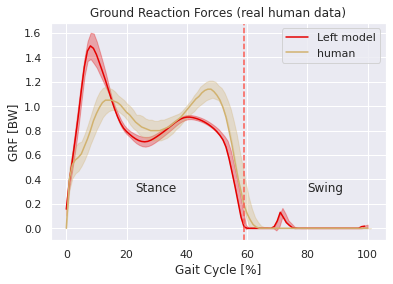

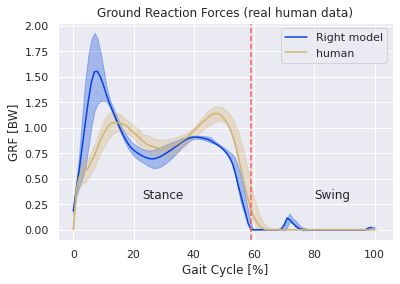

In [8]:
GRF_Y_norm_l = getNormalizedData(GRF_Y_left, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
GRF_Y_norm_r = getNormalizedData(GRF_Y_right, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)

stance_norm_l = (stance_durations_left[:]/cycle_durations_left[:]) * 100
stance_norm_r = (stance_durations_right[:]/cycle_durations_right[:]) * 100
swing_norm_l = (swing_durations_left[:]/cycle_durations_left[:]) * 100
swing_norm_r = (swing_durations_right[:]/cycle_durations_right[:]) * 100

plotWithStd(GRF_Y_norm_l, 'Ground Reaction Force for left leg', 'Gait Cycle [%]', 'GRF [%BW]', 'Left model', 'xkcd:red')
#plotStdStance(stance_norm_l, 0, 2, 'xkcd:coral', 'dashed')
plotMeanStd(GRF_mean, GRF_min, GRF_max, 'Ground Reaction Forces (real human data)', 'Gait Cycle [%]', 'GRF [BW]', 'human', 'upper right', 'xkcd:tan')
plt.axvline(59, 0, 2, color='xkcd:coral', linestyle='dashed')
plt.text(23, 0.3, 'Stance')
plt.text(80, 0.3, 'Swing')
plt.show()

plotWithStd(GRF_Y_norm_r, 'Ground Reaction Force for right leg', 'Gait Cycle [%]', 'GRF [%BW]', 'Right model', 'xkcd:blue')
plotMeanStd(GRF_mean, GRF_min, GRF_max, 'Ground Reaction Forces (real human data)', 'Gait Cycle [%]', 'GRF [BW]', 'human', 'upper right', 'xkcd:tan')
plt.axvline(59, 0, 2, color='xkcd:coral', linestyle='dashed')
plt.text(23, 0.3, 'Stance')
plt.text(80, 0.3, 'Swing')
plt.show()

From these plots, we can observe the stance and swing phases. We now want to determine the different phases durations in one cycle, as well as the duration of the various gait cycles for one optimization, for the left and right legs. 

### Muscle activations

*A developper*

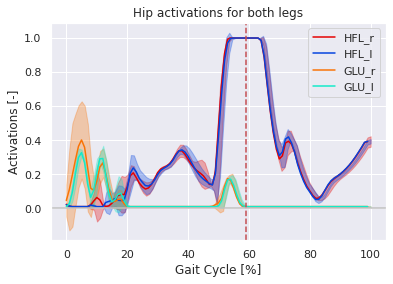

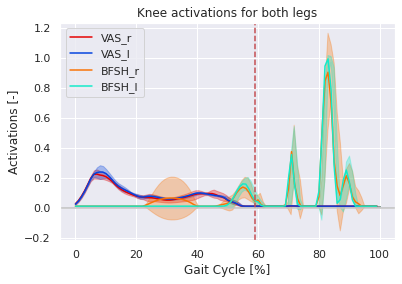

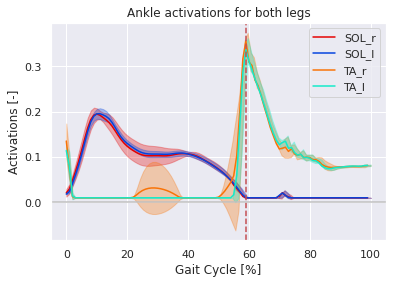

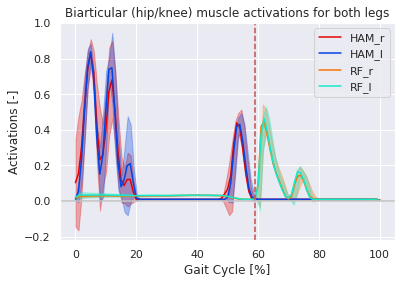

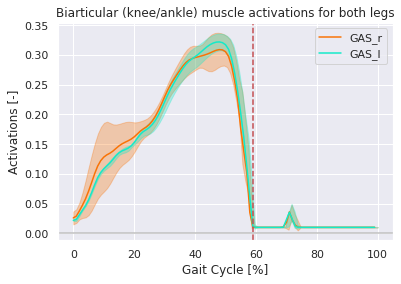

In [9]:
muscle_activations = [muscle[i] for i in range(len(muscle))]

# Muscle activations from the muscles of the right leg
HFL_r  = [item[2] for item in muscle_activations]
GLU_r  = [item[3] for item in muscle_activations]
HAM_r  = [item[4] for item in muscle_activations]
RF_r   = [item[5] for item in muscle_activations]
VAS_r  = [item[6] for item in muscle_activations]
BFSH_r = [item[7] for item in muscle_activations]
GAS_r  = [item[8] for item in muscle_activations]
SOL_r  = [item[9] for item in muscle_activations]
TA_r  = [item[10] for item in muscle_activations]

# Muscle activations from the muscles of the left leg
HFL_l  = [item[13] for item in muscle_activations]
GLU_l  = [item[14] for item in muscle_activations]
HAM_l  = [item[15] for item in muscle_activations]
RF_l   = [item[16] for item in muscle_activations]
VAS_l  = [item[17] for item in muscle_activations]
BFSH_l = [item[18] for item in muscle_activations]
GAS_l  = [item[19] for item in muscle_activations]
SOL_l  = [item[20] for item in muscle_activations]
TA_l   = [item[21] for item in muscle_activations]

# We separate the muscle activations into 5 parts: 
# - muscles involved in the hip
# - muscles involved in the knee
# - muscles involved in the ankle
# - biarticular muscles for the joint hip/knee
# - biarticular muscles for the joint knee/ankle


# Muscles involved in the hip only (HFL, GLU)
HFL_r_norm = getNormalizedData(HFL_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
HFL_l_norm = getNormalizedData(HFL_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
GLU_r_norm = getNormalizedData(GLU_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
GLU_l_norm = getNormalizedData(GLU_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)

plotWithStd(HFL_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'HFL_r', 'xkcd:red')
plotWithStd(HFL_l_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'HFL_l', 'xkcd:blue')
plotWithStd(GLU_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'GLU_r', 'xkcd:orange')
plotWithStd(GLU_l_norm, 'Hip activations for both legs', 'Gait Cycle [%]', 'Activations [-]', 'GLU_l', 'xkcd:aqua')
plt.axvline(59, 0, 2, color='r', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.show()

# Muscles involved in the knee only (VAS, BFSH)
VAS_r_norm = getNormalizedData(VAS_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
VAS_l_norm = getNormalizedData(VAS_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
BFSH_r_norm = getNormalizedData(BFSH_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
BFSH_l_norm = getNormalizedData(BFSH_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)

plotWithStd(VAS_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'VAS_r', 'xkcd:red')
plotWithStd(VAS_l_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'VAS_l', 'xkcd:blue')
plotWithStd(BFSH_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'BFSH_r', 'xkcd:orange')
plotWithStd(BFSH_l_norm, 'Knee activations for both legs', 'Gait Cycle [%]', 'Activations [-]', 'BFSH_l', 'xkcd:aqua')
plt.axvline(59, 0, 2, color='r', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.show()

# Muscles involved in the ankle only (SOL, TA)
SOL_r_norm = getNormalizedData(SOL_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
SOL_l_norm = getNormalizedData(SOL_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
TA_r_norm = getNormalizedData(TA_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
TA_l_norm = getNormalizedData(TA_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)

plotWithStd(SOL_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'SOL_r', 'xkcd:red')
plotWithStd(SOL_l_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'SOL_l', 'xkcd:blue')
plotWithStd(TA_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'TA_r', 'xkcd:orange')
plotWithStd(TA_l_norm, 'Ankle activations for both legs', 'Gait Cycle [%]', 'Activations [-]', 'TA_l', 'xkcd:aqua')
plt.axvline(59, 0, 2, color='r', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.show()

# Biarticular muscles for the joint hip/knee (HAM, RF)
HAM_r_norm = getNormalizedData(HAM_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
HAM_l_norm = getNormalizedData(HAM_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
RF_r_norm = getNormalizedData(RF_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
RF_l_norm = getNormalizedData(RF_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)

plotWithStd(HAM_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'HAM_r', 'xkcd:red')
plotWithStd(HAM_l_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'HAM_l', 'xkcd:blue')
plotWithStd(RF_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'RF_r', 'xkcd:orange')
plotWithStd(RF_l_norm, 'Biarticular (hip/knee) muscle activations for both legs', 'Gait Cycle [%]', 'Activations [-]', 'RF_l', 'xkcd:aqua')
plt.axvline(59, 0, 2, color='r', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.show()

# Biarticular muscles for the joint knee/ankle (GAS)
GAS_r_norm = getNormalizedData(GAS_r, START_CYCLE_r[:-1], START_CYCLE_r[1:]-1)
GAS_l_norm = getNormalizedData(GAS_l, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)

plotWithStd(GAS_r_norm, '', 'Gait Cycle [%]', 'Activations [-]', 'GAS_r', 'xkcd:orange')
plotWithStd(GAS_l_norm, 'Biarticular (knee/ankle) muscle activations for both legs', 'Gait Cycle [%]', 'Activations [-]', 'GAS_l', 'xkcd:aqua')
plt.axvline(59, 0, 2, color='r', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.show()


#plt.plot(np.array(reflex)[450:450+125,])
#plt.title('Reflex contributions to the motoneurons during the gait cycle')
#plt.ylabel('Reflex contributions []')
#plt.xlabel('?')
#plt.show()

### Joint Angles 

We now look at the angles from the various joints (hip, knee, ankle) and plot both legs on one graph, using again the normalized data from the values dictionnary, to plot only one gait cycle with mean and standard deviation. 

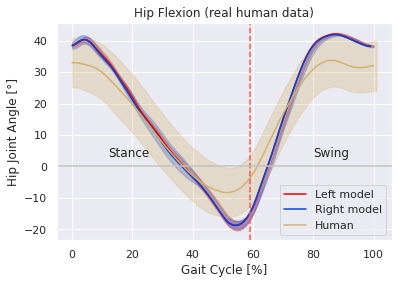

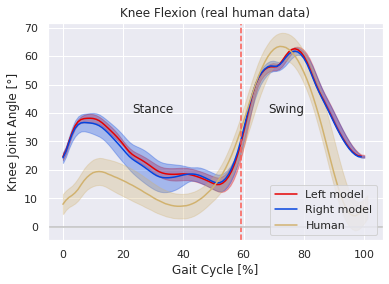

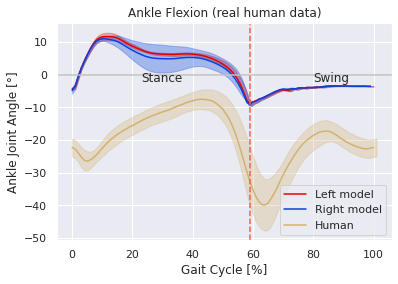

In [10]:
# Retrieve the output from the optimizations + normalization of data + mean and std plot -- HIP ANGLES
hip_angle_rleg = [(values[i]["r_leg"]["joint"]["hip"])* 180/np.pi for i in range(len(values))]
hip_angle_lleg = [(values[i]["l_leg"]["joint"]["hip"])* 180/np.pi for i in range(len(values))]

hip_norm_left = getNormalizedData(hip_angle_lleg, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
hip_norm_right = getNormalizedData(hip_angle_rleg,START_CYCLE_r[:-1],START_CYCLE_r[1:]-1)

# We multiply the norms by -1 to follow the conventions of various articles
plotWithStd(-1*hip_norm_left, '', 'Gait Cycle [%]', 'Angles [°]', 'Left model', 'xkcd:red')
plotWithStd(-1*hip_norm_right, 'Hip angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right model', 'xkcd:blue')
plotMeanStd(HipFlex_mean, HipFlex_min, HipFlex_max, 'Hip Flexion (real human data)', 'Gait Cycle [%]', 'Hip Joint Angle [°]', 'Human', 'lower right', 'xkcd:tan')
plt.axvline(59, 0, 2, color='xkcd:coral', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.text(12, 3, 'Stance')
plt.text(80, 3, 'Swing')
plt.show()

# KNEE ANGLES
knee_angle_rleg = [(values[i]["r_leg"]["joint"]["knee"])* 180/np.pi for i in range(len(values))]
knee_angle_lleg = [(values[i]["l_leg"]["joint"]["knee"])* 180/np.pi for i in range(len(values))]

knee_norm_left = getNormalizedData(knee_angle_lleg, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
knee_norm_right = getNormalizedData(knee_angle_rleg,START_CYCLE_r[:-1],START_CYCLE_r[1:]-1)

plotWithStd(-1*knee_norm_left, '', 'Gait Cycle [%]', 'Angles [°]', 'Left model', 'xkcd:red')
plotWithStd(-1*knee_norm_right, 'Knee angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right model', 'xkcd:blue')
plotMeanStd(KneeFlex_mean, KneeFlex_min, KneeFlex_max, 'Knee Flexion (real human data)', 'Gait Cycle [%]', 'Knee Joint Angle [°]', 'Human', 'lower right', 'xkcd:tan')
plt.axvline(59, 0, 2, color='xkcd:coral', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.text(23, 40, 'Stance')
plt.text(68, 40, 'Swing')
plt.show()

# ANKLE ANGLES
ankle_angle_rleg = [(values[i]["r_leg"]["joint"]["ankle"])* 180/np.pi for i in range(len(values))]
ankle_angle_lleg = [(values[i]["l_leg"]["joint"]["ankle"])* 180/np.pi for i in range(len(values))]

ankle_norm_left = getNormalizedData(ankle_angle_lleg, START_CYCLE_l[:-1], START_CYCLE_l[1:]-1)
ankle_norm_right = getNormalizedData(ankle_angle_rleg,START_CYCLE_r[:-1],START_CYCLE_r[1:]-1)

plotWithStd(-1*ankle_norm_left, '', 'Gait Cycle [%]', 'Angles [°]', 'Left model', 'xkcd:red')
plotWithStd(-1*ankle_norm_right, 'Ankle angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right model', 'xkcd:blue')
plotMeanStd(AnkleFlex_mean, AnkleFlex_min, AnkleFlex_max, 'Ankle Flexion (real human data)', 'Gait Cycle [%]', 'Ankle Joint Angle [°]', 'Human', 'lower right', 'xkcd:tan')
plt.axvline(59, 0, 2, color='xkcd:coral', linestyle='dashed')
plt.axhline(0, color='silver', linestyle='solid')
plt.text(23, -2, 'Stance')
plt.text(80, -2, 'Swing')
plt.show()

### Forces Analysis

Then, we analyze the forces of the various muscles, so as to compare them with real experimental data from EMG. We will compare the results qualitatively (mostly by doing a visual comparison) as EMGs are noisy data. 

In [8]:
#print(values[1])

# which muscles do we retrieve the forces from ? 

### Velocities

We will now study the velocity in the simulations. We set an initial speed at the beginning of each simulation, as well as a target speed, and we will try to observe whether the model follows the speed trend (from initial to target velocity). 

1.8049083781913071 0.6148437472254848


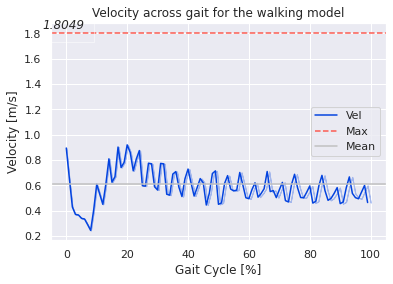

In [15]:
# Retrieve the output from the optimizations + normalization of data + mean and std plot -- VELOCITY
# for Best 350 - checkpoint 135
# initial speed = 0.9, target speed = 0.5
velocity = [(ivalues[i]["pelvis"]["vel"][0]) for i in range(len(ivalues))]
max_vel = np.max(velocity)
mean_vel = np.mean(velocity)
print(max_vel, mean_vel)

velocity_norm = getNormalizedData(velocity, [65,], [2000,])
textstr = (r'%.4f' % (max_vel, ))
plotWithStd(velocity_norm, 'Velocity across gait for the walking model', 'Gait Cycle [%]', 'Velocity [m/s]', 'Vel', 'xkcd:blue')
plt.axhline(y= max_vel, color='xkcd:coral', linestyle='--', label='Max')
plt.axhline(y = mean_vel, color='silver', linestyle='solid', label='Mean')
plt.text(-8, max_vel+0.03, textstr, style='italic', fontsize=12, 
        bbox={'facecolor': 'None', 'alpha': 0.5, 'pad': 10})
#plotStdTrend(velocity, [0,], [1000,])
plt.legend(loc='center right')
plt.show()

### Gait Analysis 

From the ground reaction forces, we could obtain the stance, swing and complete cycle durations. From this, we can count the number of steps per leg for one optimization, and determine the average step length and average step duration

In [10]:
# Number of steps determination 

full_cycle = np.append(cycle_durations_left, cycle_durations_right)
sum = 0

for i in range(0, len(full_cycle)):    
    sum = sum + full_cycle[i]

NUM_STEPS = len(LIFT_OFF_l) + len(LIFT_OFF_r)
distance = velocity[500]/sum
print(distance)

0.03415249408041557
